In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)
from numpy.random import seed
#from scipy.io import netcdf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [3]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [4]:
###########################################################################################################

In [5]:
# import sample6
grouped_t_s= pd.read_csv(f"dataset/modeling/sample6/ts.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
ave_temp= pd.read_csv(f"dataset/modeling/sample6/temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
cum_prec= pd.read_csv(f"dataset/modeling/sample6/prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(grouped_t_s.shape)
print(ave_temp.shape)
print(cum_prec.shape)

(9, 6546)
(9, 6546)
(9, 6546)


# func

In [6]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


# pick up one ts with its corresponding temp and prec, and plot them all

ts length:4240.0, freq: 1.0
(4240, 3)


Text(0.5, 1.0, 'prec')

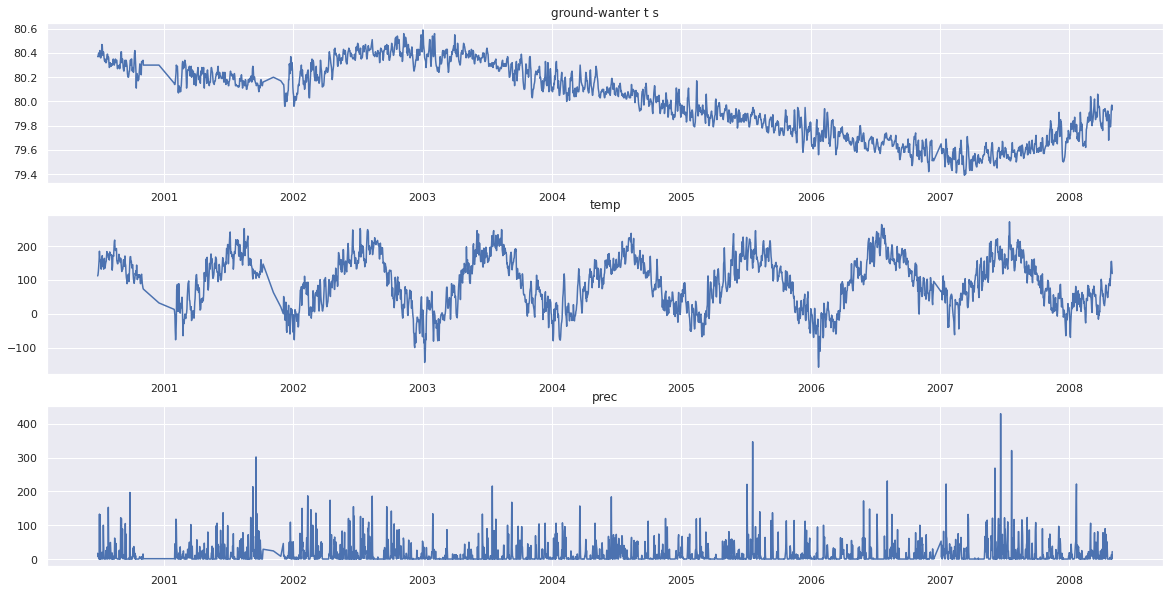

In [7]:
# apply the func
ts1 = grouped_t_s.iloc[3]
print(f"ts length:{ts1[0]}, freq: {ts1[1]}")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,2700
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

In [8]:
df.head()

,ts,temp,prec
2000-06-28,80.37,112.0,17.0
2000-06-29,80.37,116.0,7.0
2000-06-30,80.39,126.0,15.0
2000-07-01,80.40,143.0,2.0
2000-07-02,80.37,157.0,0.0


# Autoencoder LSTM model: 

In [9]:

# split df into train 80% and test 20%, 
n_train = int(len(df)*0.8)
train = df[:n_train]
test = df[n_train:]

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (3392, 1, 3)
Test data shape: (848, 1, 3)


In [10]:
# define the autoencoder network model
def autoencoder_model(X):
    # define the input vector
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # compress the input data (encoder)
    L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # distribute the compressed representational vector across the time steps of the decoder
    L3 = RepeatVector(X.shape[1])(L2)
    # decompress the  data (decoder)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    # reconstructed input data
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3)              51    

In [11]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history


Epoch 1/100
323/323 [==============================] - 7s 8ms/step - loss: 0.3199 - val_loss: 0.0674
Epoch 2/100
323/323 [==============================] - 1s 3ms/step - loss: 0.1345 - val_loss: 0.0720
Epoch 3/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0885 - val_loss: 0.0724
Epoch 4/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0819 - val_loss: 0.0756
Epoch 5/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0745 - val_loss: 0.0816
Epoch 6/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0674 - val_loss: 0.0840
Epoch 7/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0647 - val_loss: 0.0908
Epoch 8/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0636 - val_loss: 0.0851
Epoch 9/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0630 - val_loss: 0.0843
Epoch 10/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0619 - val_lo

323/323 [==============================] - 2s 5ms/step - loss: 0.0600 - val_loss: 0.0806
Epoch 82/100
323/323 [==============================] - 1s 5ms/step - loss: 0.0593 - val_loss: 0.0783
Epoch 83/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0606 - val_loss: 0.0777
Epoch 84/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0610 - val_loss: 0.0792
Epoch 85/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0609 - val_loss: 0.0770
Epoch 86/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0602 - val_loss: 0.0793
Epoch 87/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0608 - val_loss: 0.0832
Epoch 88/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0604 - val_loss: 0.0787
Epoch 89/100
323/323 [==============================] - 1s 4ms/step - loss: 0.0619 - val_loss: 0.0821
Epoch 90/100
323/323 [==============================] - 1s 3ms/step - loss: 0.0604 - val_loss: 

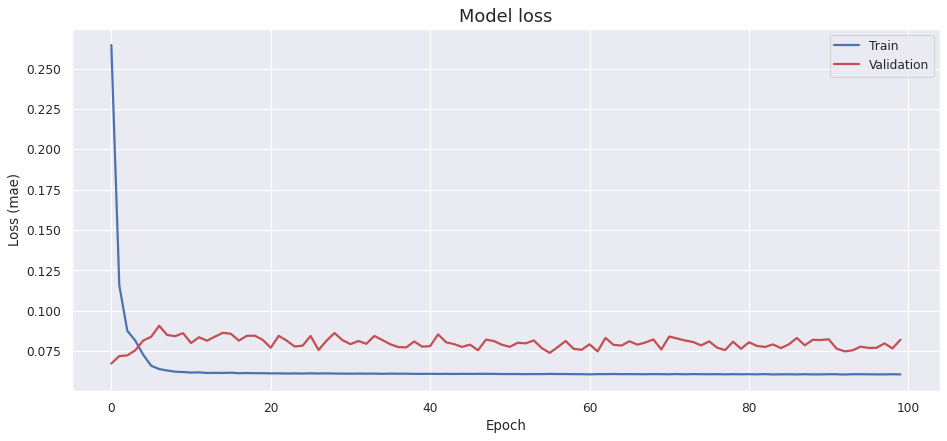

In [13]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

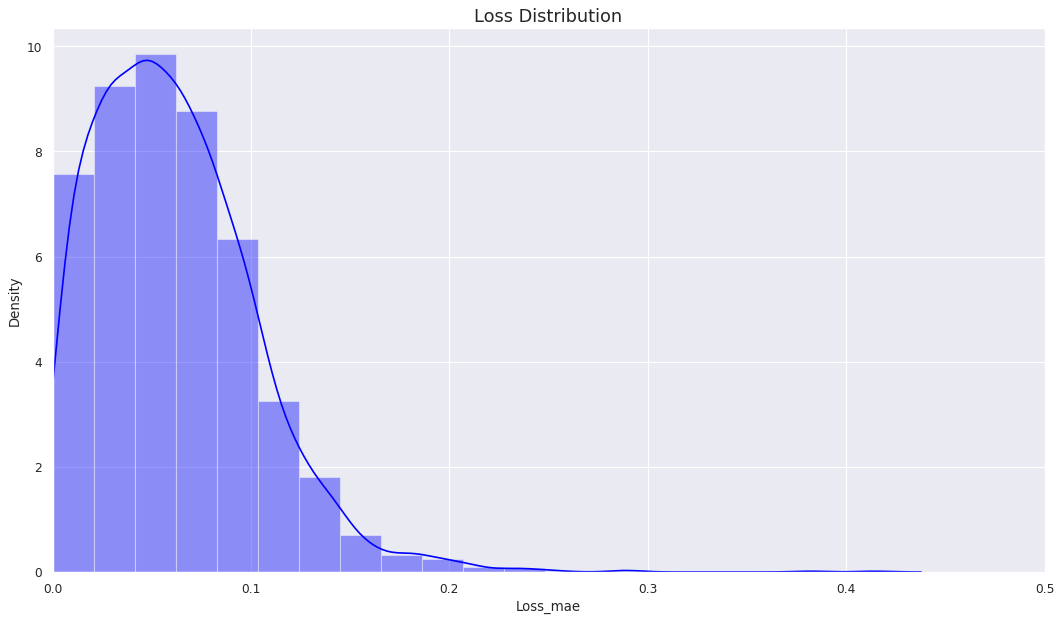

In [14]:
# plot the loss distribution of the training set
# reconstruct the training dataset (predicting)
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

# compute the loss (error between the predcted training and the original training)
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [17]:
# compute a threshold -> four std from the mean of the loss
thre = np.mean(scored,axis=0)[0]+4*np.std(scored,axis=0)[0]
thre

0.22459118656006435

In [15]:
 scored["Loss_mae"].max()

0.4138047103681033

## the outliers are the points that have loss higher than the threshold
## 

In [18]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index =test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = thre# 0.175
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2010-03-25,0.007026,0.224591,False
2010-03-26,0.094219,0.224591,False
2010-03-27,0.032557,0.224591,False
2010-03-28,0.071598,0.224591,False
2010-03-29,0.032933,0.224591,False


In [19]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = thre
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [23]:
print(scored[scored["Anomaly"]==True].shape)
scored[scored["Anomaly"]==True]

(17, 3)


,Loss_mae,Threshold,Anomaly
2001-02-04,0.225505,0.224591,True
2001-09-18,0.235728,0.224591,True
2003-07-17,0.243568,0.224591,True
2005-07-21,0.290733,0.224591,True
2006-08-05,0.230615,0.224591,True
2007-06-05,0.254301,0.224591,True
2007-06-21,0.382018,0.224591,True
2007-07-22,0.287723,0.224591,True
2008-10-30,0.232565,0.224591,True
2009-07-04,0.413805,0.224591,True


In [37]:
print(scored[scored["Anomaly"]==True].shape)
anomaly = scored[scored["Anomaly"]==True].index
anomaly

(17, 3)


Index([2001-02-04, 2001-09-18, 2003-07-17, 2005-07-21, 2006-08-05, 2007-06-05,
       2007-06-21, 2007-07-22, 2008-10-30, 2009-07-04, 2009-07-17, 2010-08-15,
       2011-07-21, 2011-07-28, 2011-07-29, 2011-12-16, 2012-02-06],
      dtype='object')

<AxesSubplot:>

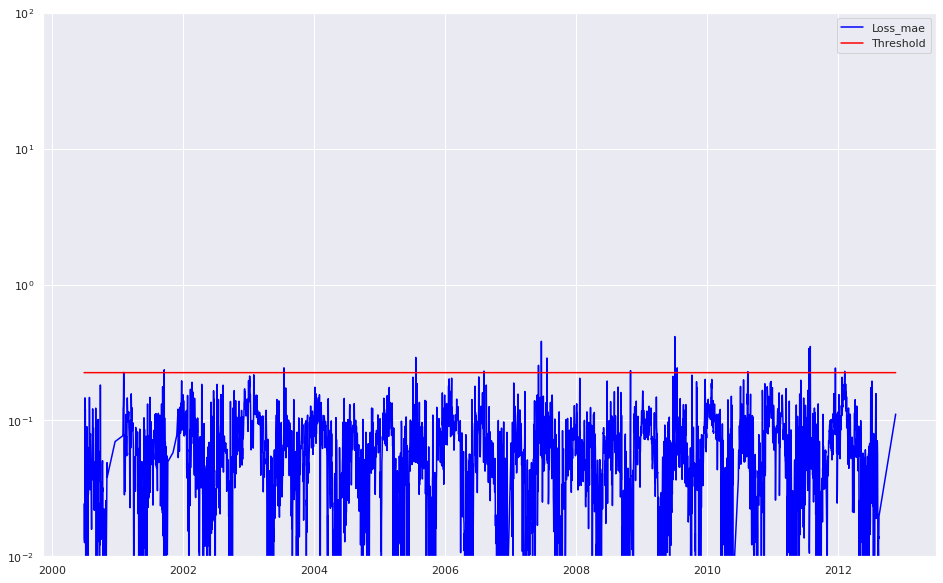

In [25]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,10), ylim=[1e-2,1e2], color=['blue','red'])


# without lag, threshold 4 std of the mean of loss

Text(0.5, 1.0, 'prec')

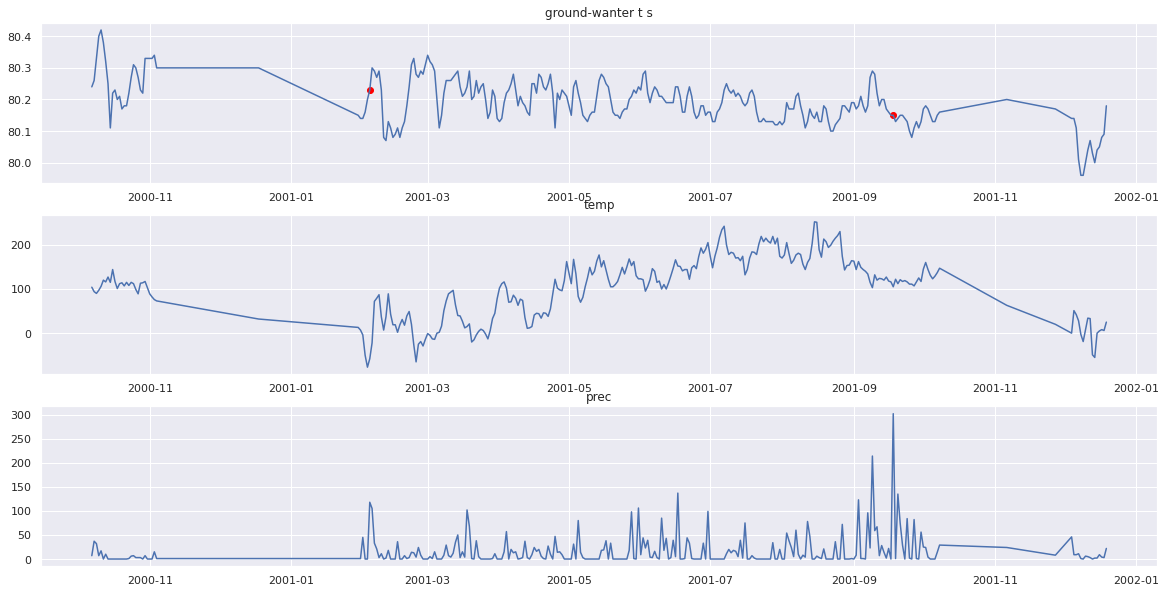

In [35]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 100,400
#a,b = 220,320
axs[0].plot(df["ts"][a:b])
axs[0].scatter(anomaly[:2], df["ts"][anomaly][:2], color="red")
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')